# Explore the ESC dataset

## Introduction
This notebook acts as the exploration of the dataset

## Goal 
Idea of the implementation, is to first look at the dataset and then create a new dataset that summarizes the data into something more suited for the "winner"-classification.

Potential columns:
1. Year, numeric <- what year
2. Country, numeric <- numeric country code
2. Semifinal, binary <- is it a semifinal?
3. Final, binary <- is it the final?
4. (**target**) Won, binary <- Did the country win?

### Additional notes
* We want the classifier to give probabilites.
* Give a prediction for this years ESC, how close were we? If we give our top 10 candidates?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("../DATA/eurovision_song_contest_1975_2018v2.csv")

In [3]:
data.head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,1975,f,1975f,J,Belgium,France,2,NaN
3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,1975,f,1975f,J,Belgium,Ireland,12,NaN


In [4]:
data.shape

(46382, 8)

In [5]:
data.isnull().sum()

Year                      0
(semi-) final             0
Edition                   0
Jury or Televoting        0
From country              0
To country                0
Points                    0
Duplicate             44980
dtype: int64

**1403 rows are duplicate?**

In [6]:
data.dtypes

Year                   int64
(semi-) final         object
Edition               object
Jury or Televoting    object
From country          object
To country            object
Points                 int64
Duplicate             object
dtype: object

**looks like we will have to do some dummy-variables** 

# Understanding the different columns

## Year
At what year was the competition?

## (semi-) final
Was it finals or semifinals?
* f final
* sfX semi-final X

## Edition
concatenaed column of Year and (semi-)final column?
* YYYYFF, YYYY <- year, FF <- f or sfX

## Jury or Televoting
From where were the points assigned?
* J, jury
* T, Televoting

## From country
Which country gave the points
* "European country"
Maybe check if there has been any namechanges?

## To country
Which country recieved the points?
* "European contry"
**Assign numeric country codes instead of names?**

## Points
The number of points given

## Duplicate
is it country X to country X?
* x, yes
* NaN, no

In [7]:
data.loc[~data.Duplicate.isnull(),].head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,1975,f,1975f,J,Belgium,Belgium,0,x
20,1975,f,1975f,J,Finland,Finland,0,x
40,1975,f,1975f,J,France,France,0,x
60,1975,f,1975f,J,Germany,Germany,0,x
80,1975,f,1975f,J,Ireland,Ireland,0,x


In [8]:
out = data.loc[~data.Duplicate.isnull(),].apply(lambda x: 1 if x["From country"] == x["To country"] else 0, axis=1)

In [9]:
out.mean()

1.0

**We should be able to drop these columns!**

In [10]:
data = data.loc[data.Duplicate.isnull(),data.columns[:-1]]

In [11]:
data.head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points
1,1975,f,1975f,J,Belgium,Finland,0
2,1975,f,1975f,J,Belgium,France,2
3,1975,f,1975f,J,Belgium,Germany,0
4,1975,f,1975f,J,Belgium,Ireland,12
5,1975,f,1975f,J,Belgium,Israel,1


# Explore the total number of points!
*hue with the type of points*

In [12]:
# clean out trailing whitespaces!
data.columns = [d.strip() for d in data.columns]

### The average number of points given (per country to country)

In [43]:
data_final = data.loc[data["(semi-) final"] == "f",]

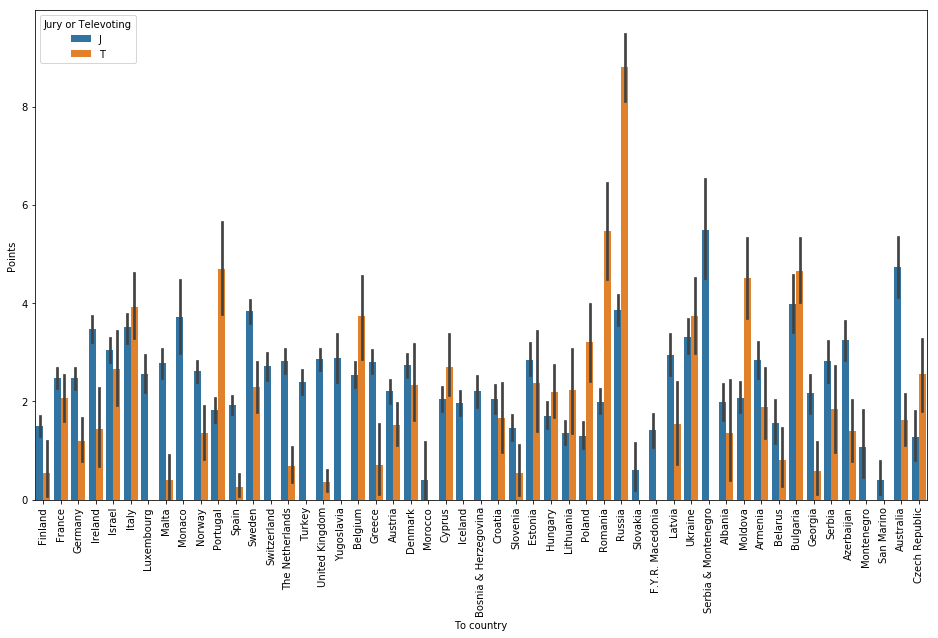

In [14]:
plt.figure(figsize=[16,9])
sns.barplot(data=data_final, x="To country", y="Points", hue="Jury or Televoting")
plt.xticks(rotation='vertical')
pass

### the total number of points recieved?

In [15]:
total_points = data_final.groupby(["To country", "Jury or Televoting"], as_index=False).Points.sum()
total_points.head()

,To country,Jury or Televoting,Points
0,Albania,J,630
1,Albania,T,58
2,Armenia,J,1121
3,Armenia,T,155
4,Australia,J,777


**should normalize the points, to its nicer to compare in plotting**

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler_j = MinMaxScaler()
scaler_t = MinMaxScaler()

In [17]:
Jpoints =scaler_j.fit_transform(np.array(total_points.loc[total_points["Jury or Televoting"] == "J",["Points"]]).reshape(-1,1))
Tpoints =scaler_t.fit_transform(np.array(total_points.loc[total_points["Jury or Televoting"] == "T",["Points"]]).reshape(-1,1))

/home/rober323/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/rober323/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [18]:
total_points.loc[total_points["Jury or Televoting"] == "J",["Points"]] = Jpoints
total_points.loc[total_points["Jury or Televoting"] == "T",["Points"]] = Tpoints

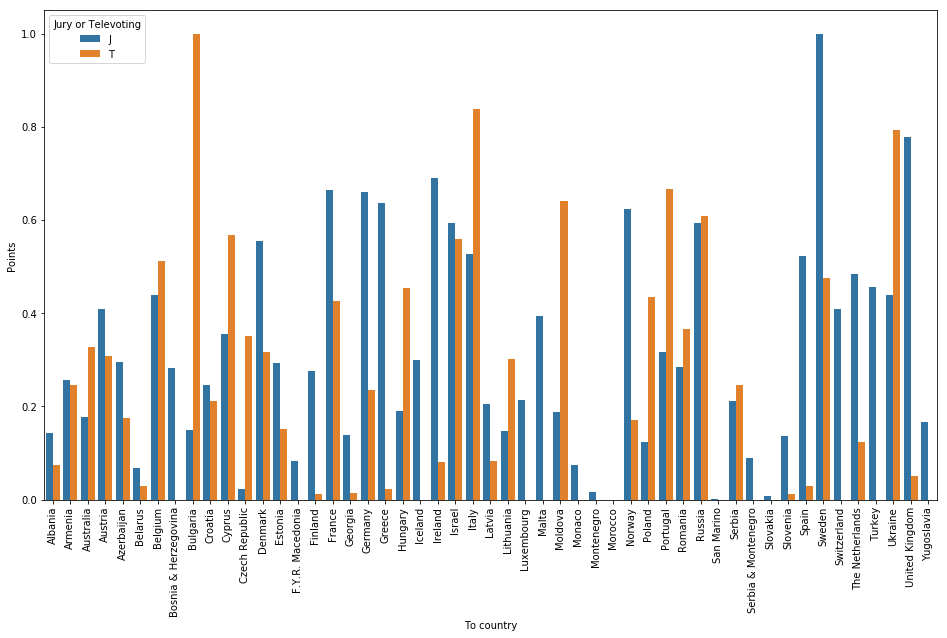

In [19]:
plt.figure(figsize=[16,9])
sns.barplot(data=total_points,
            x="To country",y="Points", hue="Jury or Televoting")
plt.xticks(rotation='vertical')
pass

### If we just group together all points

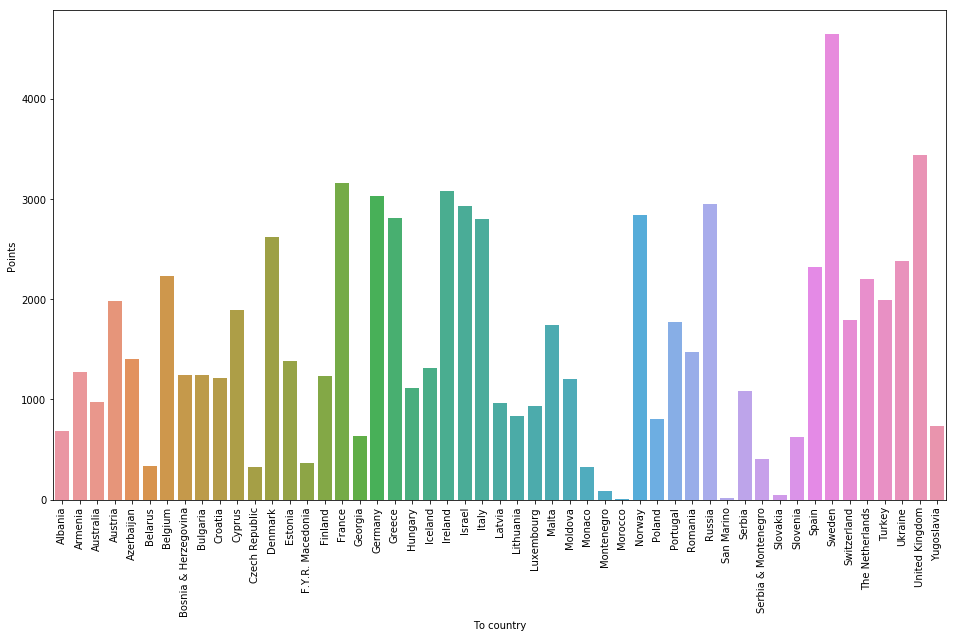

In [20]:
total_points = data_final.groupby(["To country"], as_index=False).Points.sum()

plt.figure(figsize=[16,9])
sns.barplot(data=total_points,x="To country", y="Points")
plt.xticks(rotation="vertical")
pass

## How many wins are there?
Per year and final, which country had the most points? <-- Winner
How many wins per country?

In [21]:
dt_group = data_final.groupby(["Year","To country"])["Points"].sum()

In [22]:
winnerid = dt_group.reset_index().groupby(["Year"])["Points"].apply(lambda x: x.idxmax())
winners = dt_group[winnerid].reset_index()
winners["To country"].value_counts()

Ireland            6
Sweden             4
Israel             4
Norway             3
United Kingdom     3
Germany            2
Denmark            2
France             2
Ukraine            2
Azerbaijan         1
Austria            1
Luxembourg         1
Estonia            1
The Netherlands    1
Yugoslavia         1
Belgium            1
Turkey             1
Finland            1
Latvia             1
Greece             1
Switzerland        1
Serbia             1
Italy              1
Portugal           1
Russia             1
Name: To country, dtype: int64

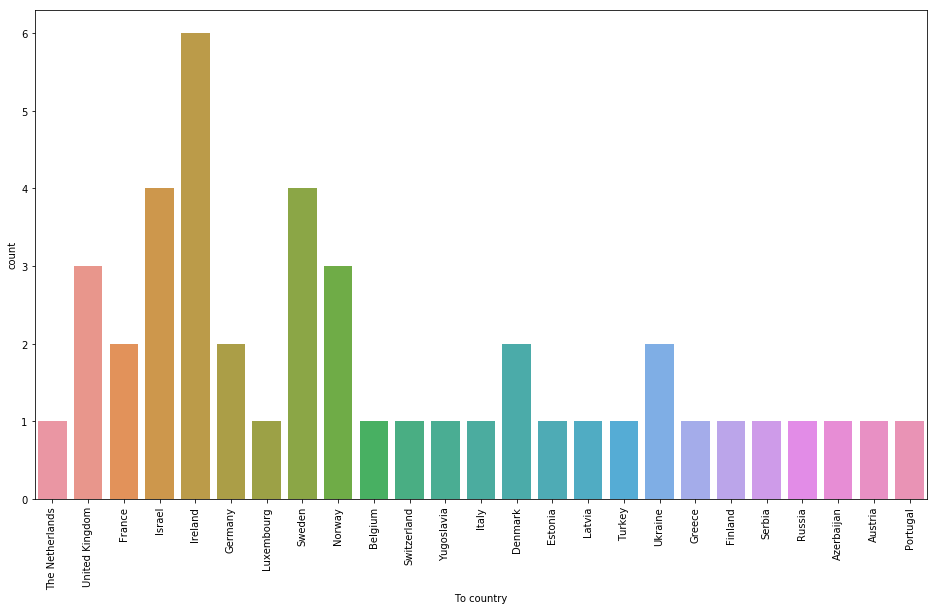

In [23]:
plt.figure(figsize=[16,9])
sns.countplot(data=winners, x= "To country")
plt.xticks(rotation="vertical")
pass

In [24]:
winners.head()

,Year,To country,Points
0,1975,The Netherlands,152
1,1976,United Kingdom,164
2,1977,France,136
3,1978,Israel,157
4,1979,Israel,125


### create a new dataframe
which holds columns
* year (numeric)
* country_id (numeric)
* win (numeric)

### and a countries dataframe
* country_id 
* name

In [261]:
# construct the different arrays
country_uniq = data["From country"].unique()
d = {"country_id": np.arange(len(country_uniq)),
     "name": country_uniq}

countries = pd.DataFrame(data=d)
countries = countries.set_index("country_id")
countries.to_csv("../DATA/countries.csv", index=False)
countries.head()

,name
country_id,
0,Belgium
1,Finland
2,France
3,Germany
4,Ireland


In [254]:
years = np.array(winners.Year)
win = np.zeros(len(years)*countries.shape[0])

# for each year, we want the countries
year_rep = np.repeat(years, countries.shape[0])
countries_tile = np.tile(countries.index,len(years))

winData = pd.DataFrame(data={"year":year_rep, "country_id": countries_tile, "win":win}, 
                       dtype="int32")
countries_temp = countries.reset_index()
year_country_id = winners.join(countries_temp.set_index("name"), on="To country")[["Year","country_id"]]

In [256]:
# iterate over each years winner

for index in range(year_country_id.shape[0]):
    year, country_id = year_country_id.iloc[index,:]
    # and say if the country won or not!
    winData.loc[(winData.country_id == country_id) & (winData.year == year), "win"] = 1

## export to csv file

In [260]:
winData.to_csv("../DATA/windata.csv", index=False)

In [183]:
winData.head()

,country_id,win,year
0,0,0,1975
1,1,0,1975
2,2,0,1975
3,3,0,1975
4,4,0,1975


# Feature engineering!
We have the basic data. Now add additional features!

Ideas:
* qualified from the SF
* last years placement

## qualified from the SF

if country is in final and in semifinal on the same year, this means that they qualified!

In [184]:
winData["sf_qualify"] = np.zeros(winData.shape[0]).astype("int32")
winData.head()

,country_id,win,year,sf_qualify
0,0,0,1975,0
1,1,0,1975,0
2,2,0,1975,0
3,3,0,1975,0
4,4,0,1975,0


In [30]:
# iterate over each year!
for y in years:
    # extract the countries in final
    inf = data.loc[(data.Year == y) & (data["(semi-) final"] == "f"),"To country"].unique()
    # the countries in any semifinal
    insf = data.loc[(data.Year == y) & (data["(semi-) final"] != "f"),"To country"].unique()
    # in both
    inboth = insf[np.isin(insf, inf)]
    # the id of the countries
    cid = countries.loc[np.isin(countries.name,inboth),].sort_values("name")["country_id"]
    # update the status
    winData.loc[(winData.year==y) & (np.isin(winData.country_id,cid)),"sf_qualify"] = 1


In [31]:
winData.corr()

,country_id,win,year,sf_qualify
country_id,1.000000,-1.085625e-01,0.000000e+00,0.014100
win,-0.108563,1.000000e+00,-1.091766e-19,0.081854
year,0.000000,-1.091766e-19,1.000000e+00,0.423622
sf_qualify,0.014100,8.185399e-02,4.236220e-01,1.000000


# placement last year?
Does the last years placement help determine how well a country perform?

In [253]:
def nameToId(topnames):
    outvec = np.zeros(topnames.shape)
    ## for each yearly group top10
    for i in range(len(topnames)):
        ## for each name in each group
        #for name in top:
        outvec[i,:] = np.array([countries.loc[np.where(countries.name == name)].index.get_values() for name in topnames[i,:]],
                            int)
    return(outvec)

In [249]:
nameToId(top10[0:2])

ValueError: could not broadcast input array from shape (10,1) into shape (10)

In [167]:
nameToId(top10[0])

KeyError: "None of [Index([(15,)], dtype='object')] are in the [index]"

In [109]:
# find which teams that were top 10 for each yeay.
dt = dt_group.reset_index()
top10 = []
for y in years:
    # find top 10 countries.
    top = dt.loc[dt.Year == y,["To country", "Points"]].sort_values("Points", ascending=False)[:10]
    top10.append(top["To country"].tolist())
top10 = np.array(top10)

In [121]:
b = np.where(np.isin(top10[0], countries.name))
b

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)

In [114]:
# convert the list entries to country ids
for top in top10[0:2]:
    for country in top:
        print(country)
        ind = np.where(country == countries.name)
        print("id: ", ind, " country: ", country)
    print("--")
    #print(np.where(top, countries.name))

The Netherlands
id:  (array([15]),)  country:  The Netherlands
United Kingdom
id:  (array([17]),)  country:  United Kingdom
Italy
id:  (array([6]),)  country:  Italy
France
id:  (array([2]),)  country:  France
Luxembourg
id:  (array([7]),)  country:  Luxembourg
Switzerland
id:  (array([14]),)  country:  Switzerland
Finland
id:  (array([1]),)  country:  Finland
Sweden
id:  (array([13]),)  country:  Sweden
Ireland
id:  (array([4]),)  country:  Ireland
Spain
id:  (array([12]),)  country:  Spain
--
United Kingdom
id:  (array([17]),)  country:  United Kingdom
France
id:  (array([2]),)  country:  France
Monaco
id:  (array([9]),)  country:  Monaco
Switzerland
id:  (array([14]),)  country:  Switzerland
Austria
id:  (array([19]),)  country:  Austria
Israel
id:  (array([5]),)  country:  Israel
Italy
id:  (array([6]),)  country:  Italy
Belgium
id:  (array([0]),)  country:  Belgium
The Netherlands
id:  (array([15]),)  country:  The Netherlands
Ireland
id:  (array([4]),)  country:  Ireland
--


# do a dummy ML approach!

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

ImportError: No module named 'catboost'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(winData.drop(columns=["win"]),
                                                   winData.win, random_state=42, 
                                                   test_size=0.3, stratify=winData.win)

In [ ]:
# design model
model = LogisticRegression()
#model_tree = RandomForestClassifier()
#model_cat = CatBoostClassifier(iterations=10000,
#                               random_seed=42,
#                               logging_level="Silent")

# fit model
model.fit(X_train,y_train)
#model_tree.fit(X_train,y_train)
#model_cat.fit(X_train,y_train,plot=True)

# predict with model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

#y_pred_tree = model_tree.predict(X_test)
#y_pred_proba_tree = model_tree.predict_proba(X_test)

#y_pred_cat = model_cat.predict(X_test)
#y_pred_proba_cat = model_cat.predict_proba(X_test)

In [ ]:
plt.plot(y_pred_proba[:,1])
plt.plot(y_pred_proba_tree[:,1])
plt.plot(y_pred_proba_cat[:,1])

### How well does it perform?


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

### test metrics
accuracy

In [ ]:
print("lr: ", accuracy_score(y_pred, y_test))
print("RF: ", accuracy_score(y_pred_tree, y_test))
print("cat:", accuracy_score(y_pred_cat, y_test))

In [ ]:
print("pred LR mean: ", np.mean(y_pred))
print("pred RF mean: ", np.mean(y_pred_tree))
print("pred CAT mean: ", np.mean(y_pred_cat))

print("test mean: ", np.mean(y_test))

confusion matrix

In [ ]:
confusion_matrix(y_pred_cat,y_test)

roc curve

In [ ]:
def roc(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
    roc_auc = auc(fpr, tpr)
    return(fpr, tpr, roc_auc)



fpr_lr, tpr_lr, roc_auc_lr = roc(y_test, y_pred_proba)
fpr_tree, tpr_tree, roc_auc_tree = roc(y_test, y_pred_proba_tree)
fpr_cat, tpr_cat, roc_auc_cat = roc(y_test, y_pred_proba_cat)


plt.figure(figsize=[8,8])
lw=2
plt.plot(fpr_lr, tpr_lr,
        lw=lw, label="ROC curve (area = %0.2f)" % roc_auc_lr)
plt.plot(fpr_tree, tpr_tree,
        lw=lw, label="ROC curve (area = %0.2f)" % roc_auc_tree)
plt.plot(fpr_cat, tpr_cat,
         lw=lw, label="ROC curve (area = %0.2f)" % roc_auc_cat)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
pass

In [ ]:
x = X_test.join(y_test)
x["pred"] = y_pred

In [ ]:
x.sort_values("year")

In [ ]:
plt.plot(y_pred,'ro')
plt.plot(y_test,'g*')

In [ ]:
y_pred.sum()